### Build & Train Model

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

*Import Data*

In [ ]:
train_df = pd.read_csv('../data/train.csv')

*Clean Running Column*

In [ ]:
def clean_running_column(df, column_name='running'):
    def convert(val):
        val = val.lower().replace(',', '').strip()
        if 'km' in val:
            return float(val.replace('km', '').strip())
        elif 'miles' in val:
            miles = float(val.replace('miles', '').strip())
            return round(miles * 1.60934, 2)
        return np.nan
    
    df['running_km'] = df[column_name].apply(convert)
    return df

*Calculate Car Age*

In [ ]:
def add_car_age(df, year_col='year', current_year=2025):
    df['car_age'] = current_year - df[year_col].astype(int)
    return df

*Convert Motor Volume to Numeric Values*

In [18]:
def conver_to_numeric(df):
    df['motor_volume'] = pd.to_numeric(df['motor_volume'], errors='coerce')
    return df

*Encode Categories*

In [21]:
def encode_categoricals(df):
    label_encoders = {}

    categorical_cols = ['model', 'motor_type', 'wheel', 'color', 'type', 'status']

    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

    return df, label_encoders

*Process Training Dataset*

In [22]:
train_df = clean_running_column(train_df)
train_df = add_car_age(train_df)
train_df = conver_to_numeric(train_df)

train_df, encoders = encode_categoricals(train_df)

train_df.dropna(inplace=True)

*Train Random Forest Model*

In [23]:
features = ['model', 'motor_type', 'wheel', 'color', 'type', 'status', 'motor_volume', 'running_km', 'car_age']
target = 'price'

x_train = train_df[features]
y_train = train_df[target]

In [24]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


*Process Test Dataset*

In [25]:
test_df = pd.read_csv('../data/test.csv')

test_df = clean_running_column(test_df)
test_df = add_car_age(test_df)
test_df = conver_to_numeric(test_df)

for col, le in encoders.items():
    if col in test_df.columns:
        test_df[col] = test_df[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

*Predict Prices*

In [27]:
x_test = test_df[features]

predictions = model.predict(x_test)
rounded_preds = predictions.round().astype(int)

*Save .csv File*

In [31]:
output_df = pd.DataFrame({
    'Id': x_test.index,
    'price': rounded_preds
})

output_df.to_csv('../outputs/predictions.csv', index=False)

### Evaluate Model

*Split training data*

In [33]:
X = train_df[features]
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

*Train evaluation model*

In [34]:
evaluation_model = RandomForestRegressor(n_estimators=100, random_state=42)
evaluation_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
y_pred = evaluation_model.predict(X_val)

*Model Scores*

In [37]:
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"📊 Mean Absolute Error (MAE):      {mae:.2f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"📈 R² Score:                        {r2:.4f}")

📊 Mean Absolute Error (MAE):      2153.09
📉 Root Mean Squared Error (RMSE): 3761.17
📈 R² Score:                        0.6785


*Evaluation Graph*

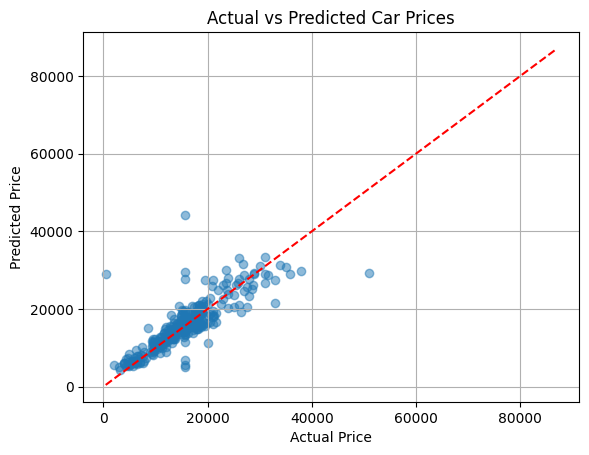

In [39]:
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ideal line
plt.grid(True)
plt.show()